In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from wordcloud import WordCloud
import networkx as nx
from functools import reduce


In [115]:
fuel_df = pd.read_csv("fuelimports.csv")
fuel_df.head()

,tradetype,districtofficecode,districtofficename,countryoforigin,countryoforiginname,countryofdestination,countryofdestinationname,tariff,statisticalunit,transportcode,...,yearmonth,calendaryear,section,sectionanddescription,chapter,chapteranddescription,tariffanddescription,statisticalquantity,customsvalue,worldregion
0,Imports,CTN,Cape Town,NG,Nigeria,ZA,South Africa,27090000,KG,0,...,201003,2010,5,5 - Mineral Products,27,"27 - Crude, Coal, Petroleum and Electricity",27090000 - Petroleum Oils And Oils Obtained Fr...,120372600.0,546876249,AFRICA
1,Imports,CTN,Cape Town,US,United States,ZA,South Africa,27121020,KG,0,...,201003,2010,5,5 - Mineral Products,27,"27 - Crude, Coal, Petroleum and Electricity",27121020 - In immediate packings of a content...,13.0,3469,AMERICA
2,Imports,CTN,Cape Town,US,United States,ZA,South Africa,27030000,KG,0,...,201003,2010,5,5 - Mineral Products,27,"27 - Crude, Coal, Petroleum and Electricity","27030000 - Peat (Including Peat Litter), Wheth...",20312.0,69173,AMERICA
3,Imports,CTN,Cape Town,US,United States,ZA,South Africa,27101147,KG,0,...,201003,2010,5,5 - Mineral Products,27,"27 - Crude, Coal, Petroleum and Electricity",27101147 - Lubricating grease,280.0,39823,AMERICA
4,Imports,CTN,Cape Town,PT,Portugal,ZA,South Africa,27121020,KG,0,...,201003,2010,5,5 - Mineral Products,27,"27 - Crude, Coal, Petroleum and Electricity",27121020 - In immediate packings of a content...,30.0,703,EUROPE


In [116]:
# check the datatypes of the variables to ensure if any need to be converted

fuel_df.dtypes

tradetype                    object
districtofficecode           object
districtofficename           object
countryoforigin              object
countryoforiginname          object
countryofdestination         object
countryofdestinationname     object
tariff                        int64
statisticalunit              object
transportcode                 int64
transportcodedescription     object
yearmonth                     int64
calendaryear                  int64
section                       int64
sectionanddescription        object
chapter                       int64
chapteranddescription        object
tariffanddescription         object
statisticalquantity         float64
customsvalue                  int64
worldregion                  object
dtype: object

In [117]:
# change 'yearmonth' and 'calenderyear' datatypes from int64 to Date

# create a new column with the parsed dates
fuel_df['yearmonth_parsed'] = pd.to_datetime(fuel_df['yearmonth'], format='%Y%d')

fuel_df['calendaryear_parsed'] = pd.to_datetime(fuel_df['calendaryear'], format='%Y')

In [118]:
# Since we are only concerned with imports to South Africa, we will drop
# all rows that have the value "Botswana" in the 'countryofdestination' column

fuel_df.drop(fuel_df[fuel_df['countryofdestinationname'] == 'Botswana'].index, inplace = True)

In [119]:
# We can also remove any irrelevant columns
# Columns with values which are represented in different columns can be removed
# Drop columns that won't be needed for our analysis

fuel_df.drop(["tradetype", "districtofficecode","countryofdestination", 
              "section", "sectionanddescription","chapter","chapteranddescription",
              'statisticalquantity',"countryoforigin"], inplace = True, axis = 1) 

In [120]:
# new data frame with split value columns 
new_df1 = fuel_df["tariffanddescription"].str.split(" - ", n = 1, expand = True) 
  
# making separate column from new data frame 
fuel_df["tariffdescription"]= new_df1[1] 
  
# Dropping old column 
fuel_df.drop(columns =["tariffanddescription"], inplace = True) 
  
# df display 
fuel_df.head() 

,districtofficename,countryoforiginname,countryofdestinationname,tariff,statisticalunit,transportcode,transportcodedescription,yearmonth,calendaryear,customsvalue,worldregion,yearmonth_parsed,calendaryear_parsed,tariffdescription
0,Cape Town,Nigeria,South Africa,27090000,KG,0,Transport mode not specified (Unknown - Other),201003,2010,546876249,AFRICA,2010-01-03,2010-01-01,Petroleum Oils And Oils Obtained From Bitumino...
1,Cape Town,United States,South Africa,27121020,KG,0,Transport mode not specified (Unknown - Other),201003,2010,3469,AMERICA,2010-01-03,2010-01-01,In immediate packings of a content exceeding ...
2,Cape Town,United States,South Africa,27030000,KG,0,Transport mode not specified (Unknown - Other),201003,2010,69173,AMERICA,2010-01-03,2010-01-01,"Peat (Including Peat Litter), Whether Or Not A..."
3,Cape Town,United States,South Africa,27101147,KG,0,Transport mode not specified (Unknown - Other),201003,2010,39823,AMERICA,2010-01-03,2010-01-01,Lubricating grease
4,Cape Town,Portugal,South Africa,27121020,KG,0,Transport mode not specified (Unknown - Other),201003,2010,703,EUROPE,2010-01-03,2010-01-01,In immediate packings of a content exceeding ...


In [121]:
missing_values_count = fuel_df.isnull().sum()

# look at the # of missing points in the dataset
missing_values_count

districtofficename          0
countryoforiginname         0
countryofdestinationname    0
tariff                      0
statisticalunit             0
transportcode               0
transportcodedescription    0
yearmonth                   0
calendaryear                0
customsvalue                0
worldregion                 0
yearmonth_parsed            0
calendaryear_parsed         0
tariffdescription           0
dtype: int64

In [122]:
# how many total missing values do we have?
total_cells = np.product(fuel_df.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
(total_missing/total_cells) * 100

0.0

# Relations between features


# Biggest importer of fuel to South Africa

In [123]:
# frequency count of 'country' column 
count = fuel_df['countryoforiginname'].value_counts() 
print(count)

Germany                      151
United States                120
Netherlands                   50
United Kingdom                49
Botswana                      45
Lesotho                       39
Namibia                       39
Belgium                       35
India                         34
France                        32
Japan                         30
Swaziland                     28
China                         26
United Arab Emirates          24
Spain                         23
Canada                        22
Sweden                        16
Italy                         16
Mozambique                    16
South Korea                   15
Austria                       14
Australia                     13
Singapore                     13
Ireland                       12
South Africa                  11
Malaysia                      10
Bahrain                        9
Saudi Arabia                   9
Egypt                          7
Turkey                         7
Zimbabwe  

## Majority of the fuel South Africa imports is from Germany and the USA.
## Biggest exports to South Africa are as follows:
### 1) Germany
### 2) United States of America
### 3) Netherlands
### 4) United Kingdom
### 5) Botswana

# Tariffs by country

In [124]:
group_by_country = fuel_df.groupby(by=['countryoforiginname'])

# Find the mean value of point of each region
tariff_avg = round(group_by_country.mean(),0)

In [125]:
# Sort the grouped data according to tariff

tariff_avg.sort_values("tariff", ascending = False, inplace = True)    # Regions with the highest points
tariff_avg.sort_values("tariff", ascending = True, inplace = True)     # Regions with the lowest points

tariff_avg.head(5)

,tariff,transportcode,yearmonth,calendaryear,customsvalue
countryoforiginname,,,,,
Tanzania,27011900.0,0.0,201004.0,2010.0,10080.0
Madagascar,27011900.0,0.0,201002.0,2010.0,910.0
Latvia,27030000.0,0.0,201003.0,2010.0,34129.0
Ireland,27030000.0,0.0,201002.0,2010.0,79513.0
Finland,27033333.0,0.0,201003.0,2010.0,29525.0


## Countries with the highest tariffs:
### 1) Indonesia
### 2) Portugal
### 3) Czech Republic
### 4) Thailand
### 5) Brazil

## Countries with the lowest tariffs:
### 1) Tanzania
### 2) Madagascar
### 3) Latvia
### 4) Ireland
### 5) Finland


# Frequency of types of fuel

In [126]:
count = fuel_df['tariffdescription'].value_counts() 
print(count)

Other                                                                                                                                                         186
Lubricating grease                                                                                                                                             99
Other prepared lubricating oils                                                                                                                                95
Paraffin wax                                                                                                                                                   56
Prepared lubricating oils, in containers holding less than 5 li                                                                                                55
Peat (Including Peat Litter), Whether Or Not Agglomerated                                                                                                      53
Distillate fuel, as defined 

## Most of the fuel imported to South Africa is used for lubrication in some form, as well as for paraffin wax, distillate fuel and petrol.

In [127]:
group_by_definition = fuel_df.groupby(by=['tariffdescription'])

#Find the mean value of point of each definition
avg = round(group_by_definition.mean(),0)

avg.sort_values("tariff", ascending = False, inplace = True)  

avg.head()

,tariff,transportcode,yearmonth,calendaryear,customsvalue
tariffdescription,,,,,
Electrical Energy,27160000.0,0.0,201002.0,2010.0,152514982.0
Emulsions,27150010.0,0.0,201002.0,2010.0,387289.0
"Bitumen and asphalt, containing 60 per cent or more by mass of mineral matter",27149020.0,0.0,201002.0,2010.0,90522.0
Bituminous Or Oil Shale And Tar Sands,27141000.0,3.0,201002.0,2010.0,30293.0
Petroleum Bitumen,27132000.0,0.0,201002.0,2010.0,113131.0


In [128]:
avg.sort_values("tariff", ascending = True, inplace = True)     # descriptions with the lowest tariffs

avg.head()

,tariff,transportcode,yearmonth,calendaryear,customsvalue
tariffdescription,,,,,
Anthracite,27011100.0,2.0,201014.0,2010.0,3052586.0
Bituminous Coal,27011200.0,2.0,201003.0,2010.0,9799475.0
Other Coal,27011900.0,1.0,201007.0,2010.0,344046.0
"Briquettes, Ovoids And Similar Solid Fuels Manufactured From Coal",27012000.0,2.0,201002.0,2010.0,41345.0
"Lignite, Whether Or Not Pulverised, But Not Agglomerated",27021000.0,0.0,201002.0,2010.0,37770.0


## Fuel with the highest tariffs:
### 1) Electrical Energy
### 2) Emulsions
### 3) Bitumen and asphalt, containing 60 per cent or more by mass of mineral matter
### 4) Bituminous Or Oil Shale And Tar Sands
### 5) Petroleum Bitumen

## Fuel with the lowest tariffs:
### 1) Anthracite
### 2) Bituminous Coal
### 3) Other coal
### 4) Briquettes, Ovoids And Similar Solid Fuels Manufactured From Coal
### 5) Lignite, Whether Or Not Pulverised, But Not Agglomerated


# Total value of different imports

In [129]:
# To find the total cost of imports add the tariff to the custom value
fuel_df['totalcost'] = fuel_df['tariff'] + fuel_df['customsvalue']

# top 5 most expensive imports
fuel_df.nlargest(5, ['totalcost']) 

,districtofficename,countryoforiginname,countryofdestinationname,tariff,statisticalunit,transportcode,transportcodedescription,yearmonth,calendaryear,customsvalue,worldregion,yearmonth_parsed,calendaryear_parsed,tariffdescription,totalcost
556,Durban,Saudi Arabia,South Africa,27090000,KG,0,Transport mode not specified (Unknown - Other),201003,2010,2245123098,ASIA,2010-01-03,2010-01-01,Petroleum Oils And Oils Obtained From Bitumino...,2272213098
437,Durban,Angola,South Africa,27090000,KG,0,Transport mode not specified (Unknown - Other),201002,2010,2095555560,AFRICA,2010-01-02,2010-01-01,Petroleum Oils And Oils Obtained From Bitumino...,2122645560
965,Durban,Iran,South Africa,27090000,KG,0,Transport mode not specified (Unknown - Other),201004,2010,1982519337,ASIA,2010-01-04,2010-01-01,Petroleum Oils And Oils Obtained From Bitumino...,2009609337
454,Durban,Iran,South Africa,27090000,KG,0,Transport mode not specified (Unknown - Other),201002,2010,1818984165,ASIA,2010-01-02,2010-01-01,Petroleum Oils And Oils Obtained From Bitumino...,1846074165
86,Durban,Iran,South Africa,27090000,KG,0,Transport mode not specified (Unknown - Other),201001,2010,1641024917,ASIA,2010-01-01,2010-01-01,Petroleum Oils And Oils Obtained From Bitumino...,1668114917


In [130]:
# 5 least expensive imports
fuel_df.nsmallest(5, ['totalcost']) 

,districtofficename,countryoforiginname,countryofdestinationname,tariff,statisticalunit,transportcode,transportcodedescription,yearmonth,calendaryear,customsvalue,worldregion,yearmonth_parsed,calendaryear_parsed,tariffdescription,totalcost
890,Ficksburg Bridge,Lesotho,South Africa,27011100,KG,3,Road,201004,2010,120,AFRICA,2010-01-04,2010-01-01,Anthracite,27011220
804,O.R. Tambo Int Airport,Netherlands,South Africa,27012000,KG,0,Transport mode not specified (Unknown - Other),201003,2010,15,EUROPE,2010-01-03,2010-01-01,"Briquettes, Ovoids And Similar Solid Fuels Man...",27012015
664,O.R. Tambo Int Airport,Madagascar,South Africa,27011900,KG,0,Transport mode not specified (Unknown - Other),201003,2010,167,AFRICA,2010-01-03,2010-01-01,Other Coal,27012067
330,Oshoek,Swaziland,South Africa,27012000,KG,3,Road,201002,2010,83,AFRICA,2010-01-02,2010-01-01,"Briquettes, Ovoids And Similar Solid Fuels Man...",27012083
256,Oshoek,Swaziland,South Africa,27012000,KG,3,Road,201001,2010,155,AFRICA,2010-01-01,2010-01-01,"Briquettes, Ovoids And Similar Solid Fuels Man...",27012155


## 5 most expensive imports:
### 1) Petroleum Oils And Oils Obtained From Bituminous Minerals, Crude - Saudi Arabia
### 2) Petroleum Oils And Oils Obtained From Bituminous Minerals, Crude - Angola
### 3) Petroleum Oils And Oils Obtained From Bituminous Minerals, Crude - Iran
### 4) Petroleum Oils And Oils Obtained From Bituminous Minerals, Crude - Iran
### 5) Petroleum Oils And Oils Obtained From Bituminous Minerals, Crude - Iran

## 5 least expensive imports in our dataframes:
### 1) Anthracite - Lesotho
### 2) Briquettes, Ovoids And Similar Solid Fuels Manufactured From Coal - Netherlands
### 3) Other coal - Madagascar
### 4) Briquettes, Ovoids And Similar Solid Fuels Manufactured From Coal - Swaziland
### 5) Briquettes, Ovoids And Similar Solid Fuels Manufactured From Coal - Swaziland



## Visualization of data 

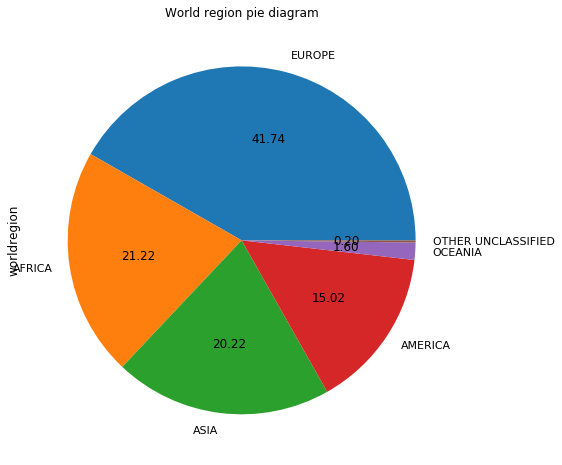

In [131]:
fuel_df['worldregion'].value_counts().plot.pie(figsize=(8, 8), autopct='%.2f')
plt.title("World region pie diagram");

plt.savefig('piechart.png')

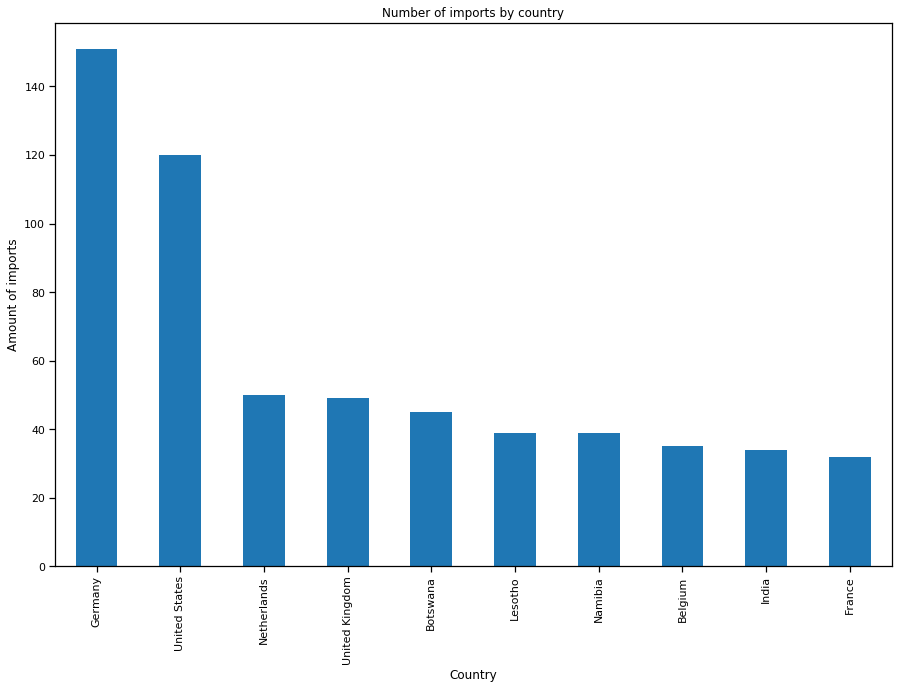

In [132]:
import matplotlib.pyplot as plt
%matplotlib inline

fuel_df.countryoforiginname.value_counts().nlargest(10).plot(kind='bar', figsize=(15,10))
plt.title("Number of imports by country")
plt.ylabel('Amount of imports')
plt.xlabel('Country');

plt.savefig("originbar.png")

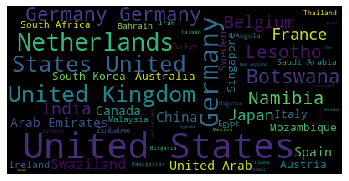

In [133]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# create a word cloud for 'countryoforigin'
wordcloud2 = WordCloud().generate(' '.join(fuel_df['countryoforiginname']))

# Generate plot
plt.imshow(wordcloud2)
plt.axis("off")

plt.savefig("wordcloud.png")

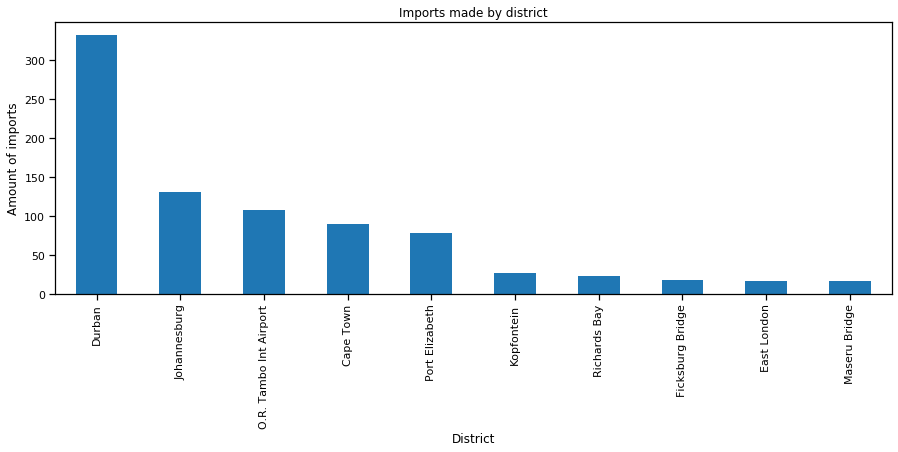

In [134]:
fuel_df.districtofficename.value_counts().nlargest(10).plot(kind='bar', figsize=(15,5))
plt.title("Imports made by district")
plt.ylabel('Amount of imports')
plt.xlabel('District');

plt.savefig("districtbar.png")

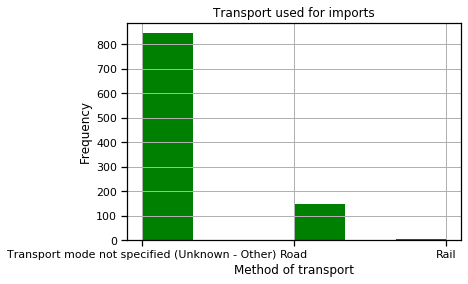

In [135]:
# Method of transport histogram

fuel_df.transportcodedescription.hist(bins=6,color='green');
plt.title("Transport used for imports")
plt.ylabel('Frequency')
plt.xlabel('Method of transport');

plt.savefig("trasnportusedhist.png")

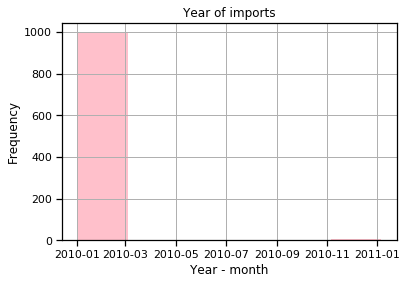

In [136]:
# Year-month of import histogram

fuel_df.yearmonth_parsed.hist(bins=6,color='pink');
plt.title("Year of imports")
plt.ylabel('Frequency')
plt.xlabel('Year - month');

plt.savefig("yearmonth.png")

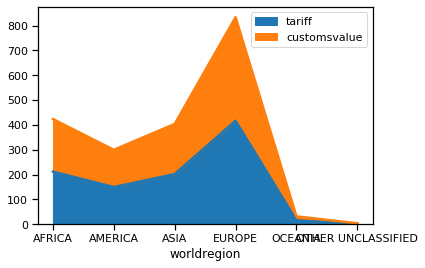

In [137]:
group_by_worldregion = fuel_df.groupby(by=['worldregion'])

avg = round(group_by_worldregion.count(),0)

features_of_interest = pd.DataFrame({'tariff': avg['tariff'],
                                     'customsvalue': avg['customsvalue'],
                                    
                                   }
                                   )

features_of_interest.plot.area(stacked=True)

plt.savefig("tariffarea.png")

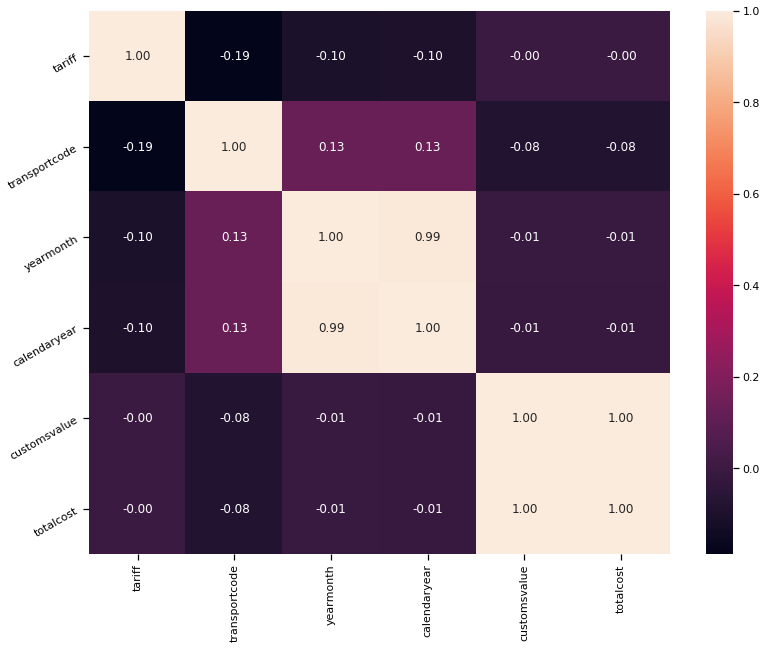

In [138]:
import seaborn as sns

corr = fuel_df.corr()
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(13,10))
a = sns.heatmap(corr, annot=True, fmt='.2f')
rotx = a.set_xticklabels(a.get_xticklabels(), rotation=90)
roty = a.set_yticklabels(a.get_yticklabels(), rotation=30)

plt.savefig("heatmap.png")

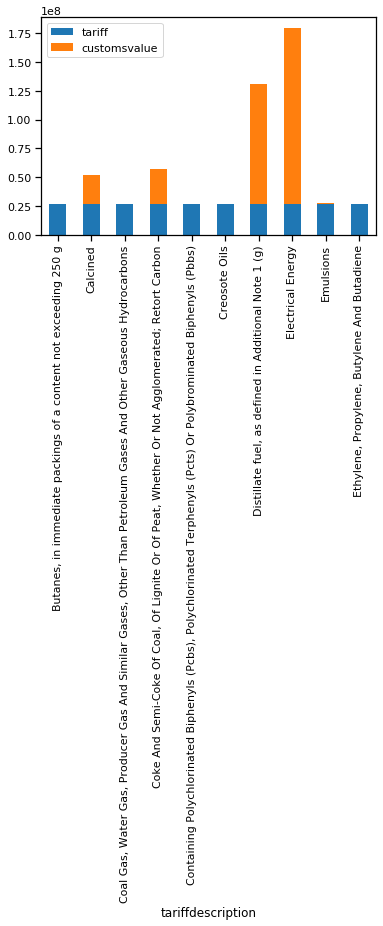

In [139]:
group_by_description = fuel_df.groupby(by=['tariffdescription'])

avg = round(group_by_description.mean(),0)


features_of_interest = pd.DataFrame({'tariff': avg['tariff'],
                                     'customsvalue': avg['customsvalue'],
                                   }
                                   )

features_of_interest = features_of_interest.iloc[10:20,]

features_of_interest.plot.bar(stacked=True)

plt.savefig("tariffbarstacked.png", bbox_inches="tight")

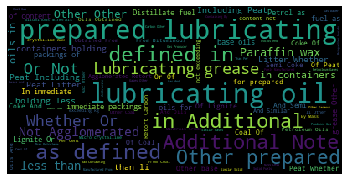

<Figure size 432x288 with 0 Axes>

In [140]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# create a word cloud for 'tariffdescription'
wordcloud2 = WordCloud().generate(' '.join(fuel_df['tariffdescription']))

# Generate plot
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

plt.savefig("descriptionwordcloud.png", bbox_inches = "tight")

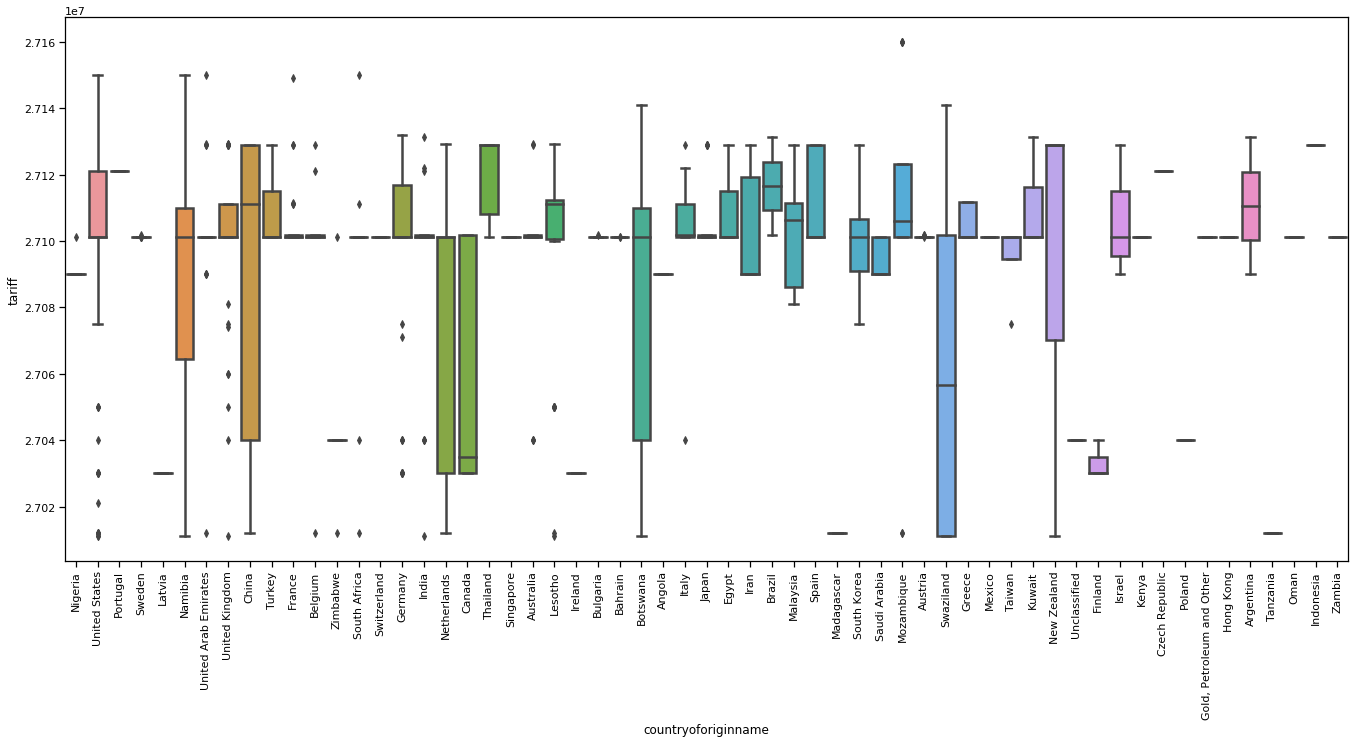

In [146]:
plt.rcParams['figure.figsize']=(23,10)
ax = sns.boxplot(x="countryoforiginname", y="tariff", data= fuel_df)

plt.xticks(rotation = 90)

plt.savefig("boxandwhiskerstariffs.png", bbox_inch = "tight")